# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
df.query('group == "treatment" & landing_page != "new_page"').shape[0]

1965

In [7]:
df[(df['group']=='treatment') & (df['landing_page']!='new_page')].shape[0]

1965

**f.** Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

**a.** Create a new dataset that meets the required specifications. Store your new dataframe in **df2**.

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df[(df['group']=='control') & (df['landing_page']=='old_page')]
df1 = df[(df['group']=='treatment') & (df['landing_page']=='new_page')]

df2 = df2.merge(df1, how='outer')

In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  

**a.** How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [12]:
duplicate = df2.user_id.value_counts().sort_values(ascending=False).index[0]
duplicate

773192

**c.** Display the rows for the duplicate **user_id**? 

In [13]:
df2[df2['user_id']==duplicate]

,user_id,timestamp,group,landing_page,converted
146212,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
146678,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
# Remove one of the rows with a duplicate user_id..
df2.drop(df2[df2['user_id']==duplicate].index[1], axis=0, inplace=True)

### ToDo 1.4  


**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [15]:
p_population = df2.converted.mean()
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control = df2[df2['group']=='control'].converted.mean()
control

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment = df2[df2['group']=='treatment'].converted.mean()
treatment

0.11880806551510564

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment - control
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [19]:
newpage_p = df2[df2['landing_page']=='new_page'].landing_page.count()/df2.landing_page.count()
newpage_p

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**From the above reaults, it is observed that the treatment group users led to less conversions than control group users.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

>$H_0$: $p_{new}$ - $p_{old}$ <= 0
>
>$H_1$: $p_{new}$ - $p_{old}$ > 0

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [22]:
n_new = df2[df2['group']=='treatment'].user_id.nunique()
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2[df2['group']=='control'].user_id.nunique()
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [24]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1,0], size=n_new, p=[p_new,1-p_new], replace=True)

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [25]:
# Simulate a Sample for the control Group
old_page_converted =  np.random.choice([1,0], size=n_new, p=[p_old,1-p_old], replace=True)

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [26]:
p_diff = new_page_converted.mean() - old_page_converted.mean()
p_diff

0.002188424747092424


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [27]:
# Sampling distribution 
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([1,0], size=n_new, p=[p_new,1-p_new], replace=True)
    old_page_converted =  np.random.choice([1,0], size=n_new, p=[p_old,1-p_old], replace=True)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


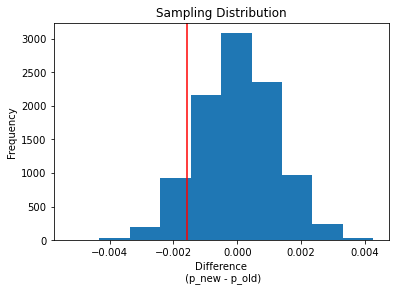

In [28]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
plt.axvline(obs_diff, color='red')
plt.xlabel('Difference\n (p_new - p_old)')
plt.ylabel('Frequency')
plt.title('Sampling Distribution')
plt.show()

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [29]:
(p_diffs > obs_diff).mean()

0.9019

**k.** What does this value mean in terms of whether or not there is a difference between the new and old pages?

>**The value calculated above is p-value. It suggests that 90% of the differences from our sampling distribution under null hypothesis are greater than our observed difference from dataset. With a Type I error rate of 5%, the p_value is greater than 0.05. Thus, we fail to reject the null hypothesis.**



### Using Built-in Methods for Hypothesis Testing<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Calculate:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [30]:
# number of conversions with the old_page
convert_old = df2.query('group=="control"')['converted'].sum()

# number of conversions with the new_page
convert_new = df2.query('group=="treatment"')['converted'].sum()

# number of individuals who were shown the old_page
n_old = df2.query('group=="control"')['user_id'].count()

# number of individuals who received new_page
n_new = df2.query('group=="treatment"')['user_id'].count()

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 

In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.





In [31]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old], alternative='larger')
z_score, p_value

/Users/aryantalathi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/aryantalathi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


(-1.3109241984234394, 0.9050583127590245)

In [32]:
 #critical value of 95% confidence
from scipy.stats import norm
critical_value = norm.ppf(1-(0.05))

In [33]:
print('Z-Score:',round(z_score,4),'\nCritical Value of 5% Type I Error:',round(critical_value,4))

Z-Score: -1.3109 
Critical Value of 5% Type I Error: 1.6449


In [34]:
print('\np-Value:',round(p_value,4),'\nType I Error:',0.05)


p-Value: 0.9051 
Type I Error: 0.05


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Observed z-score is less than the critical value at 95% confidence interval. And, p-value is much greater than type I error rate. Hence, we fail to reject the null-hypothesis.They agree with findings from part j and k.**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic Regression.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [35]:
df2['intercept'] = 1
df2[['old_page','ab_page']] = pd.get_dummies(df2['group'])
df2.drop('old_page',axis=1, inplace=True)
df2

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0
...,...,...,...,...,...,...,...
290580,677163,2017-01-03 19:41:51.902148,treatment,new_page,0,1,1
290581,925675,2017-01-07 20:38:26.346410,treatment,new_page,0,1,1
290582,643562,2017-01-02 19:20:05.460595,treatment,new_page,0,1,1
290583,822004,2017-01-04 03:36:46.071379,treatment,new_page,0,1,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [36]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Aug 2022   Pseudo R-squ.:               8.077e-06
Time:                        23:46:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

>**The p-value assosiated with ab_page is 0.190. This is different from the p-value from Part III (0.907). Supposedly this is due to the difference in types of hypothesis for both parts. Also, in Regression model, we have to account for the intercept as well.**


>**Hypothesis in Part III (Regression Model) are:**
>
>H0: pnew−pold=0
>
>H1: pnew−pold!=0
>
>
> **Hypothesis in Part II were:**
>
>H0: pnew−pold<=0
>
>H1: pnew−pold>
0

>**Hypothesis in Part III are two-sided whereas in Part II were one-sided.**
>
>**Current p-value (0.190) is greater than Type I error rate of 0.05. Hence, we fail to reject the null hypothesis.**

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**There can be numerous other factors like age, gender, occupation, etc. which can influence the result of conversion. Considering additional factors will make our equation strong and reduce the confidence interval. There may be a disadvantage that the additional factor we consider is corelated to one of the existing explanatory factor. In that case, we would have to take into account Multicolinearity.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged` 

2. Does it appear that country had an impact on conversion? 

 Provide the statistical output as well as a written response to answer this question.

In [38]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [39]:
# Join with the df2 dataframe
df_merged = df2.merge(countries, left_on='user_id', right_on='user_id')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US
3,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,US
4,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,US


In [40]:
# Create the necessary dummy variables
df_merged[['CA','UK','US']] = pd.get_dummies(df_merged['country'])

In [43]:
# Fit your model, and summarize the results
log_mod = sm.Logit(df_merged['converted'],df_merged[['intercept','ab_page','CA','US']])
results =log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 24 Aug 2022   Pseudo R-squ.:               2.323e-05
Time:                        23:48:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

> **All the p-values are greater than 0.05 (Type I error rate). Hence, we fail to reject the null hypothesis.**

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an **interaction** between page and country to see if are there significant effects on conversion. Create the necessary additional columns, and fit the new model.

Provide the summary results (statistical output), and your conclusions (written response) based on the results. 


In [45]:
df_merged['CA_ab_page'] = df_merged['CA']*df_merged['ab_page']
df_merged['US_ab_page'] = df_merged['US']*df_merged['ab_page']

In [46]:
# Fit your model, and summarize the results
log_mod = sm.Logit(df_merged['converted'],df_merged[['intercept','ab_page','CA','US', 'CA_ab_page', 'US_ab_page']])
results =log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 24 Aug 2022   Pseudo R-squ.:               3.482e-05
Time:                        23:49:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US             0.0057      0.019      0.306      0.760      -0.031       0.043
CA_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
US_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
==============================================================================
"""

>**We can see that adding additional columns has increased the p-value of each factor/column. They are all greater than 0.05 (Type I error rate). Thus, decreasing their statistical significance. Adding additional columns hasn't provided any benefit for the hypothesis testing in this case.**

## Conclusions

>**From both the parts (Part II and Part III) we conclude that, none of the factors have p-values which are significant (lesser than 0.05). Hence, we fail to reject the null hypothesis. We will require further more evidence/data in order to test the. Hence it is advised to run the experiment longer.**


*Additional Notes:*
> **The dataset provided has each entry pertaining to a certain timestamp. The factor of time can also influence the result of conversion. Adding time column in our model will certainly help to increase accuracy of our testing.**
